Hello, I'm a student learning ML. Here's my approach to this task. 

This competition deals with titanic - like problem, it also uses similar dataset.

I used general methods of manipulating data and added some key features for 0.81 score of my own.







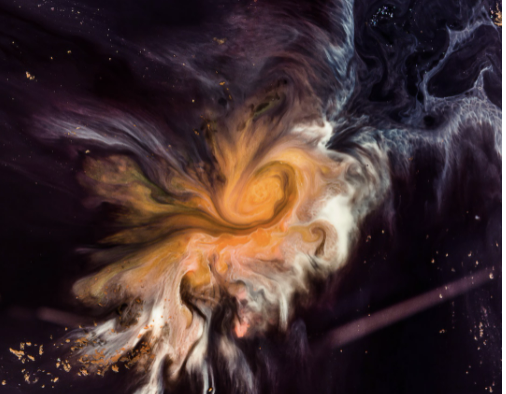

I should also mention that this notebook barely shows any EDA, so if you want to see matrixes, graphics or visualisations, then I recommend this work which I also used https://www.kaggle.com/code/arootda/pycaret-visualization-optimization-0-81. This notebook is made purely to show my general ideas on how to get 0.81 score.

First load needed libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from scipy import stats
import os
from IPython.core.display import HTML

Set custom seed for reproducability


In [ ]:
seed=1337
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(seed)


Load data


In [ ]:
train=pd.read_csv('../input/spaceship-titanic/train.csv')
test=pd.read_csv('../input/spaceship-titanic/test.csv')
pID=train['PassengerId']
#train=train.drop(columns=['PassengerId'])
#test=test.drop(columns=['PassengerId'])

In [ ]:
cats=['HomePlanet','Cabin','Destination','CryoSleep','VIP','Name']

In [ ]:
train.head()

CHECK NANS

In [ ]:
def show_nan(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    print(missing_value_df)
show_nan(train)
print()
#show_nan(test)

Filling None values. In my opinion its logical to fill bill values with 0 since if theres no record then no money was spent. Other values are filled with mean.


In [ ]:
#RoomService, FoodCourt, ShoppingMall, Spa, VRDeck fillna 0

train['RoomService']=train['RoomService'].fillna(0)
train['FoodCourt']=train['FoodCourt'].fillna(0)
train['ShoppingMall']=train['ShoppingMall'].fillna(0)
train['Spa']=train['Spa'].fillna(0)
train['VRDeck']=train['VRDeck'].fillna(0)

test['RoomService']=test['RoomService'].fillna(0)
test['FoodCourt']=test['FoodCourt'].fillna(0)
test['ShoppingMall']=test['ShoppingMall'].fillna(0)
test['Spa']=test['Spa'].fillna(0)
test['VRDeck']=test['VRDeck'].fillna(0)


for i in train.columns:
    if train[i].isna().sum()>0:

        if i not in cats:
            train[i]=train[i].fillna(train.groupby('Transported')[i].transform('mean'))
for i in test.columns:
    if test[i].isna().sum()>0:

        if i not in cats:
            test[i]=test[i].fillna(test[i].mean())
'''        if i in cats:
            train[i]=train[i].fillna(method="ffill")'''

Split cabin into deck,num,size as suggested by data overview

In [ ]:
train['Cabin']=train['Cabin'].fillna(method='ffill')
test['Cabin']=test['Cabin'].fillna(method='ffill')

train['deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['num'] = train['Cabin'].apply(lambda x: x.split('/')[1])
train['side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

test['deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['num'] = test['Cabin'].apply(lambda x: x.split('/')[1])
test['side'] = test['Cabin'].apply(lambda x: x.split('/')[2])


'''
#show_nan(train)
t = pd.concat([train['PassengerId'],train['Cabin']], axis=1, keys=['PassengerId','Cabin'])
t_t = pd.concat([test['PassengerId'],test['Cabin']], axis=1, keys=['PassengerId','Cabin'])
t=t.dropna()
t_t=t_t.dropna()
t['deck'] = t['Cabin'].apply(lambda x: x.split('/')[0])
t['num'] = t['Cabin'].apply(lambda x: x.split('/')[1])
t['side'] = t['Cabin'].apply(lambda x: x.split('/')[2])

t_t['deck'] = t_t['Cabin'].apply(lambda x: x.split('/')[0])
t_t['num'] = t_t['Cabin'].apply(lambda x: x.split('/')[1])
t_t['side'] = t_t['Cabin'].apply(lambda x: x.split('/')[2])

del t['Cabin'],t_t['Cabin']

train=train.merge(t,on='PassengerId',how='left')
test=test.merge(t_t,on='PassengerId',how='left')

train['CryoSleep']=train['CryoSleep'].fillna(False)
test['CryoSleep']=test['CryoSleep'].fillna(False)
train['VIP']=train['VIP'].fillna(True)
test['VIP']=test['VIP'].fillna(True)
train=train.fillna('missing_val')
test=test.fillna('missing_val')
'''

del train['Cabin'],test['Cabin']
cats.remove('Cabin')
cats.append('deck')
cats.append('num')
cats.append('side')

Filling CryoSleep with False proved to be best, but you can try filling CryoSleep based on total spend of money by person (people who spent 0 money are in cryosleep).

In [ ]:
train['CryoSleep']=train['CryoSleep'].fillna(False)
test['CryoSleep']=test['CryoSleep'].fillna(False)

Uncomment to fill categorical values with their most frequent value. (only for test)


In [ ]:

for i in test.columns:
    if test[i].isna().sum()>0:
        if i in cats:
            test[i]=test[i].fillna(test[i].value_counts(ascending=True).index[-1])
            
            

Here I tried to split name by surname to find how many people are there with the same surname. It proved to be unefficient.

In [ ]:

'''train['last_name']=train['Name'].apply(lambda x: str(x).split(' ')[1])
d=train['last_name'].value_counts().to_dict()
train['has_relatives']=train['last_name'].map(d)
print(max(train['has_relatives']))
del train['last_name']

test['last_name']=test['Name'].apply(lambda x: str(x).split(' ')[1])
d=test['last_name'].value_counts().to_dict()
test['has_relatives']=test['last_name'].map(d)
print(max(test['has_relatives']))
del test['last_name']'''
#del train['Name']
#del test['Name']
cats.remove('Name')

In following code passenger id is split to get group number for later.

In [ ]:
#print(train['PassengerId'])
train['group']=train['PassengerId'].apply(lambda x: x.split('_')[0])
test['group']=test['PassengerId'].apply(lambda x: x.split('_')[0])


Now, using groups and surnames we can check how many relatives are there in the same group.

In [ ]:
train['Name']=train['Name'].fillna(method='ffill')
test['Name']=test['Name'].fillna(method='ffill')
temp=pd.DataFrame(train.groupby(['group'])['Name'])
d={}
for i in range(len(temp)):#len(temp)
    past_last_names=[]
    names=list(temp[1][i])
    rltvs=1
    for j in range(len(list(temp[1][i]))):#len(list(temp[1][i]))
        if(names[j].split(' ')[1] in past_last_names):
            rltvs+=1
        past_last_names.append(names[j].split(' ')[1])

    d[f"{temp[0][i]}"]=rltvs

train['has_relatives']=train['group'].map(d)


temp=pd.DataFrame(test.groupby(['group'])['Name'])
d={}
for i in range(len(temp)):#len(temp)
    past_last_names=[]
    names=list(temp[1][i])
    rltvs=1
    for j in range(len(list(temp[1][i]))):#len(list(temp[1][i]))
        if(names[j].split(' ')[1] in past_last_names):
            rltvs+=1
        past_last_names.append(names[j].split(' ')[1])
    d[f"{temp[0][i]}"]=rltvs

test['has_relatives']=test['group'].map(d)
print(train)
del train['Name'],train['group']
del test['Name'],test['group']

In [ ]:
#train['rs_diff']=train['RoomService']-train['FoodCourt']-train['ShoppingMall']-train['Spa']-train['VRDeck']
#test['rs_diff']=test['RoomService']-test['FoodCourt']-test['ShoppingMall']-test['Spa']-test['VRDeck']

Total spend by person

In [ ]:
#RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
train['ttl_spnd']=train['RoomService']+train['FoodCourt']+train['ShoppingMall']+train['Spa']+train['VRDeck']
test['ttl_spnd']=test['RoomService']+test['FoodCourt']+test['ShoppingMall']+test['Spa']+test['VRDeck']
'''
train['RS_part']=train['RoomService']/train['ttl_spnd']
train['FC_part']=train['FoodCourt']/train['ttl_spnd']
train['SM_part']=train['ShoppingMall']/train['ttl_spnd']
train['S_part']=train['Spa']/train['ttl_spnd']
train['VR_part']=train['VRDeck']/train['ttl_spnd']

test['RS_part']=test['RoomService']/test['ttl_spnd']
test['FC_part']=test['FoodCourt']/test['ttl_spnd']
test['SM_part']=test['ShoppingMall']/test['ttl_spnd']
test['S_part']=test['Spa']/test['ttl_spnd']
test['VR_part']=test['VRDeck']/test['ttl_spnd']'''

#del train['VR_part'],train['S_part'],train['ShoppingMall'],train['FoodCourt'],train['RS_part']
#del test['VR_part'],test['S_part'],test['ShoppingMall'],test['FoodCourt'],test['RS_part']

Check if person is adult or not

In [ ]:
train['Adult']=True
train.loc[train['Age']<18, 'Adult']=False
test['Adult']=True
test.loc[test['Age']<18, 'Adult']=False

In [ ]:
print(cats)

Encode categorical values. Nan values will be encoded too.

In [ ]:
from sklearn.preprocessing import LabelEncoder
#cats=['HomePlanet','Cabin','Destination','CryoSleep','VIP']
#print(train['CryoSleep'])
for i in cats:
    print(i)
    le=LabelEncoder()
    arr=np.concatenate((train[i], test[i])).astype(str)
    le.fit(arr)
    train[i]=le.transform(train[i].astype(str))
    test[i]=le.transform(test[i].astype(str))
#print(train['CryoSleep'])

In [ ]:
t=train['Transported']
del train['Transported']
train['Transported']=t

Scatter plot for each column by Transported

In [ ]:
def shw(train):
    for i in range(len(train.columns)-1):
        if train.columns[i] not in cats:
            plt.figure()
            plt.title(train.columns[i])
            plt.scatter(train[train.columns[i]],train['Transported'],alpha=0.1)
            plt.show()
not_cats=['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
'''
shw(train)
print(len(train))

for i in not_cats:
    for j in range(len(train)):
        if np.abs(train[i][j]-train[i].mean()>3*train[i].std()):
            train[i][j]=None
train=train.dropna()


print(len(train))
shw(train)'''

Check value counts

In [ ]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

multi_table([pd.DataFrame(train[i].value_counts()*100/len(train)) for i in train.columns if i != 'Age'])



In [ ]:
multi_table([pd.DataFrame((test[i].value_counts()*100 )/len(test)) for i in test.columns if i != 'Age'])

Correlation heatmap


In [ ]:
t1=train#.drop(columns=cats)

sns.set_theme(font_scale=3)
plt.figure(figsize=(50,50))
sns.heatmap(t1.corr(), annot=True)
plt.show()

In [ ]:
'''t2=train.drop(columns=not_cats)
contigency= pd.crosstab(t2,columns=t2.columns) 
plt.figure(figsize=(12,8)) 
sns.heatmap(contigency, annot=True, cmap="YlGnBu")'''

Splittus value is used to either split by train and validation, or not for final training

In [ ]:
splittus=True

Split values

In [ ]:

y=train['Transported']
y=y.astype(int)
#cats.remove('VIP')
print(train.columns)
if splittus:
    from sklearn.model_selection import train_test_split

    X=train.drop(columns=['Transported','PassengerId'])

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=seed,shuffle=True)
else:
    X_train=train.drop(columns=['Transported','PassengerId'])
    y_train=y

I'm using Catboost since I'm generally familiar with it and it gives great performance too.

In [ ]:
from catboost import CatBoostClassifier
model=CatBoostClassifier(iterations=1000,#random_strength=0.1,cat_features=cats
                         eval_metric='Accuracy',
                        verbose=0)
if splittus:
    model.fit(X_train,y_train,eval_set=(X_val,y_val),use_best_model=True)
else:
    model.fit(X_train,y_train)
print(model.get_best_iteration())
print(model.random_seed_)
print(model.learning_rate_)

Check accuracy (auc is somewhat the same usually)

In [ ]:
if splittus:
    from sklearn.metrics import accuracy_score
    out=model.predict(X_val)
    out_t=model.predict(X_train)
    
    print(accuracy_score(y_train.values,out_t))
    print(accuracy_score(y_val.values,out))
    
'''
0.8518177634606535
0.8256669733210672
'''

In [ ]:
#test.head()

In [ ]:
test=test.drop(columns=['PassengerId'])

ans=model.predict(test)
ans=ans.astype(bool)
#ans.loc[ans['Transported']==0,'Transported']=False
#ans.loc[ans['Transported']==1,'Transported']=True

Get answers

In [ ]:
sub=pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
sub['Transported']=ans
sub.to_csv('./submission.csv',index=False)

In [ ]:
print('Code finished')

Also I should mention that for some reason code with splitting performs far better than code that uses full data